# Customer Lifetime Value Modeling

Dataset: https://www.kaggle.com/vijayuv/onlineretail

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifetimes
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/anaconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## 1. Probablistic Model: BG/NBD, Gamma-Gamma Model
LTV = expected number of transactions * revenue per transactions * margin    
- BG/NBD model: predict 1) expected number of transactions; 2) probability of being alive    
- Gamma-Gamma model: predict expected monetary value per transaction    
- Margin is defined by business, e.g., discount, campaign, something relates to the price

In [3]:
df = pd.read_csv("Online+Retail.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26,3.39,17850.0,United Kingdom


### 1.1 Data preprocessing

In [6]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

#### Data cleansing
customerID: remove missing values, because the model is built on specific customers.    
Quantity: remove negative records (the data is based on accounting records, positive records have related negative records)

In [5]:
dfnew = df[(df.Quantity>0) & (df.CustomerID.isnull() == False)]

dfnew['amt'] = dfnew['Quantity'] * dfnew['UnitPrice']
dfnew['InvoiceDate'] = pd.to_datetime(dfnew['InvoiceDate']).dt.date

#### EDA
- 4339 customers
- 397,924 transactions
- Date: 2010-12-01 to 2011-12-09
- Average CLV: 2053.79, median CLV: 674.45

In [8]:
print(dfnew['InvoiceDate'].min())
print(dfnew['InvoiceDate'].max())

2010-12-01
2011-12-09


In [6]:
# number of customers
dfnew['CustomerID'].nunique()

4339

In [7]:
# number of transactions
dfnew.shape

(397924, 9)

In [10]:
cust = dfnew.groupby(['CustomerID']).agg({
    'InvoiceNo': 'count',
    'amt': 'sum'
}).reset_index()

In [11]:
cust.describe()

,CustomerID,InvoiceNo,amt
count,4339.000000,4339.000000,4339.000000
mean,15299.936852,91.708689,2053.793018
std,1721.889758,228.792852,8988.248381
min,12346.000000,1.000000,0.000000
25%,13812.500000,17.000000,307.245000
50%,15299.000000,41.000000,674.450000
75%,16778.500000,100.000000,1661.640000
max,18287.000000,7847.000000,280206.020000


### 1.2 Feature aggregation
The lifetime package is based on transaction data only. For each customer, aggregate:
- recency: days between first and last purchase in the given period.
- frequency: number of repeated purchase in the given period. More precisely, it's the count of days the customer had a repeated purchase on.
- T: customer age, days since first purchase.
- monetary_value: transaction value in the given period.

In [13]:
from lifetimes.plotting import *
from lifetimes.utils import *

modeldata = summary_data_from_transaction_data(dfnew, 'CustomerID', 'InvoiceDate', 
                                               monetary_value_col='amt', 
                                               observation_period_end='2011-12-9')
modeldata.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
0.3569946992394561


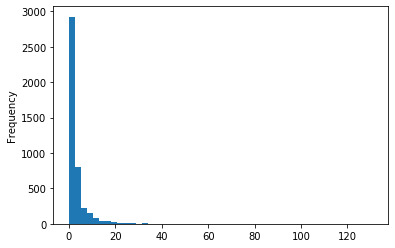

In [11]:
modeldata['frequency'].plot(kind='hist', bins=50)
print(modeldata['frequency'].describe())
# frequency=0 means no repeated purchase. 35.7% customers left after one purchase.
print(sum(modeldata['frequency'] == 0)/float(len(modeldata)))

### 1.3 BG/NBD model
Beta-Geometric/Negative Binomial Distribution Model
#### 1.3.1 Assumptions

1. When a user is active, the number of his transactions in a time period of length t is described by Poisson distribution with transaction rate λ.
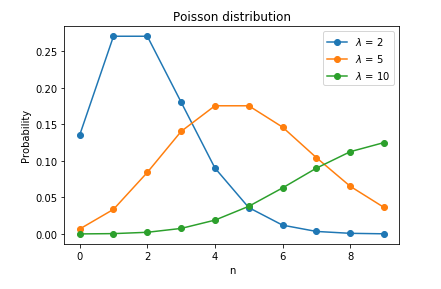

2. Transaction rate λ has Gamma distribution with parameters r (shape) and α (scale).
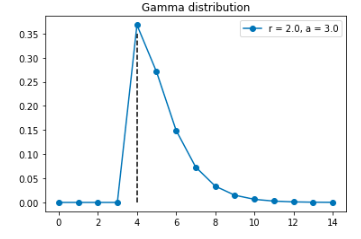

3. Users may become inactive after any transaction with probability p and their dropout point is distributed between purchases with Geometric distribution.
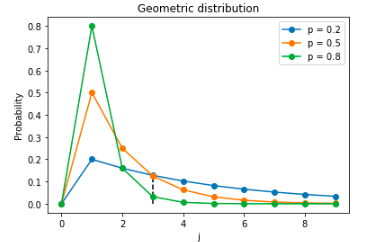

4. Dropout probability p has Beta distribution with the two shape parameters α and β.
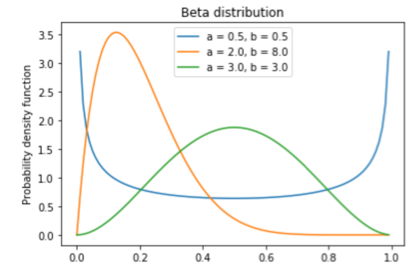

5. Transaction rate and dropout probability independently vary across users.

In [14]:
from lifetimes import BetaGeoFitter

# penalizer_coef: regularization, to prevent overfitting especially when the dataset is small, can set 0 when dataset is large enough
bgf = BetaGeoFitter(penalizer_coef=0.0)

# fit BG model on the whole data
bgf.fit(modeldata['frequency'], modeldata['recency'], modeldata['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


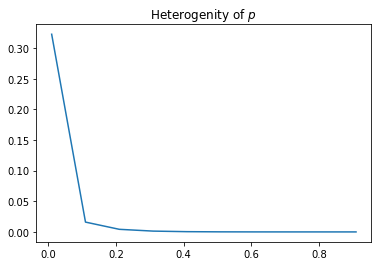

mean:  0.0005098191370874716
median:  3.267989632629193e-89
std:  0.008107144035249531


In [45]:
from scipy.stats import gamma, beta

x = np.arange (0.01, 1, 0.1)
a, b = bgf.params_['a'], bgf.params_['b']
gbd = beta.pdf(x, a, b)
plt.figure(figsize=(6,4))
plt.title('Heterogenity of $p$')
temp = plt.plot(x, gbd)
plt.show()
print('mean: ', beta.mean(a, b))
print('median: ', beta.median(a, b))
print('std: ', beta.std(a, b))

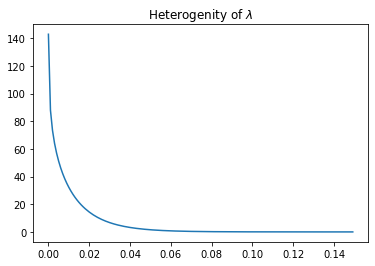

mean:  0.011996297994156649
median:  0.007641762756333042
std:  0.01319603301914138


In [46]:
x = np.arange (0.0001, 0.15, 0.001)
r, alpha = bgf.params_['r'], bgf.params_['alpha']
ggd = gamma.pdf(x, r, scale=1.0/alpha)
plt.figure(figsize=(6,4))
plt.title('Heterogenity of $\lambda$')
temp = plt.plot(x, ggd)
plt.show()
print('mean: ', gamma.mean(r, scale=1.0/alpha))
print('median: ', gamma.median(r, scale=1.0/alpha))
print('std: ', gamma.std(r, scale=1.0/alpha))

In [17]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826433,0.026780,0.773944,0.878922
alpha,68.890678,2.611055,63.773011,74.008345
a,0.003443,0.010347,-0.016837,0.023722
b,6.749363,22.412933,-37.179985,50.678711


#### 1.3.2 Frequency-recency matrix

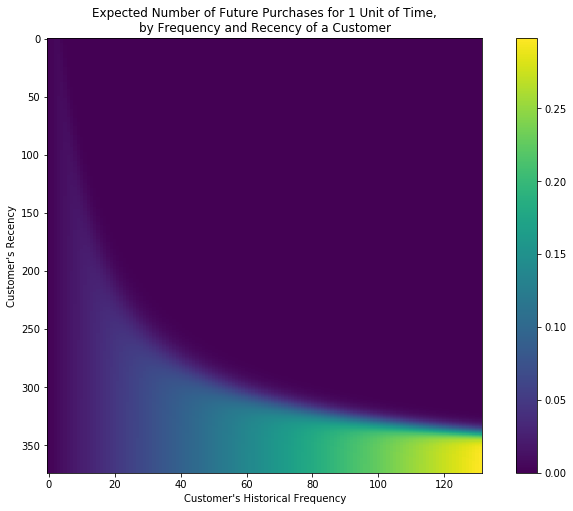

In [16]:
from lifetimes.plotting import plot_frequency_recency_matrix

fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

Target: expected number of purchase in next 1 day    
X-axis: frequency    
Y-axis: recency    
- Up-right: dark, rare chance of purchase, people have high frequency, but rarely buy things recently, they might quit the product/your business
- Diagonal: blue curve, relatively good customer    

**Recency is more important than frequency**. People with good recency (bottom) is more likely to buy than people with high frequency but bad recency (up right).

#### 1.3.3 Churn/Active Probability

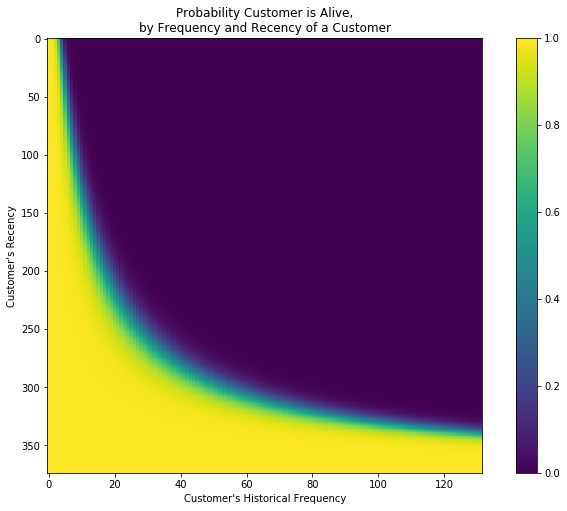

In [15]:
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

- Up-right: dead/silent
- Bottom-left: high activity. Active probability decrease exponentially with recency (time between first and last purchase) decrease.

#### 1.3.4 Predict future transaction number

In [17]:
t = 1  # in the next 1 day
modeldata['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, modeldata['frequency'], modeldata['recency'], modeldata['T'])


In [18]:
# Highest 5 customers
modeldata.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,0.201005
15311.0,89.0,373.0,373.0,677.729438,0.203269
17841.0,111.0,372.0,373.0,364.452162,0.253053
12748.0,113.0,373.0,373.0,298.360885,0.257581
14911.0,131.0,372.0,373.0,1093.661679,0.298312


In [19]:
# Lowest 5 customers
modeldata.sort_values(by='predicted_purchases').head(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
18074.0,0.0,0.0,373.0,0.0,0.00187
16048.0,0.0,0.0,373.0,0.0,0.00187
16274.0,0.0,0.0,373.0,0.0,0.00187
14237.0,0.0,0.0,373.0,0.0,0.00187
14142.0,0.0,0.0,373.0,0.0,0.00187


#### 1.3.5 Model validation: period transaction plot

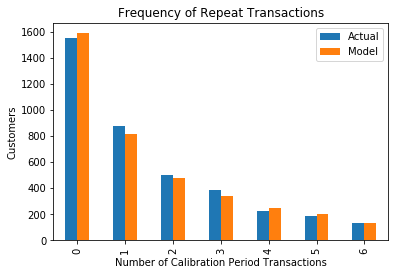

In [20]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

X-axis: number of transactions in calibration period (whole training data)    
Error: gap between two bars    

The model is good because:
-	**accurate**: Gaps between two bars are small
-	**stable**: Two bars decline consistently.    
If the pattern (two bars) is not declining consistently, the model is not stable.
-	There are both positive and negative errors, the error is random.     
If the model prediction is always larger/smaller than actual, the model is not good because the error is not random, there’s still room for the model to be improved.

#### 1.3.6 Model validation: split calibration and holdout sets
Partition data into two parts. Fit the model on calibration (train) set, test on future/holdout.

In [47]:
summary_cal_holdout = calibration_and_holdout_data(dfnew, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-08-31',
                                        observation_period_end='2011-12-09' )

In [48]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.0,0.0,0.0,225.0,0.0,100
12347.0,4.0,238.0,267.0,2.0,100
12348.0,2.0,110.0,258.0,1.0,100
12350.0,0.0,0.0,210.0,0.0,100
12352.0,3.0,34.0,196.0,3.0,100


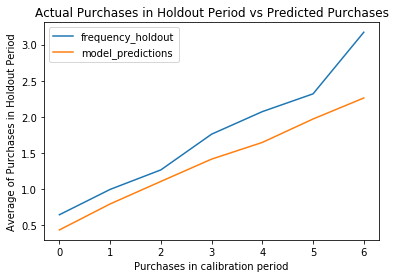

In [49]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf2 = BetaGeoFitter(penalizer_coef=0.0)
bgf2.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf2, summary_cal_holdout)

The model is good because model prediction (orange line) and true data (blue line) overlap.

In [51]:
summary_cal_holdout['predicted_purchases'] = bgf2.conditional_expected_number_of_purchases_up_to_time(100, summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])


In [52]:
summary_cal_holdout

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,predicted_purchases
CustomerID,,,,,,
12346.0,0.0,0.0,225.0,0.0,100,0.248374
12347.0,4.0,238.0,267.0,2.0,100,1.418368
12348.0,2.0,110.0,258.0,1.0,100,0.840423
12350.0,0.0,0.0,210.0,0.0,100,0.261874
12352.0,3.0,34.0,196.0,3.0,100,1.421056
...,...,...,...,...,...,...
18280.0,0.0,0.0,177.0,0.0,100,0.297442
18281.0,0.0,0.0,80.0,0.0,100,0.495104
18282.0,0.0,0.0,26.0,1.0,100,0.785817


In [59]:
from sklearn.metrics import mean_squared_error, r2_score

def smape(y_true, y_pred):
    difference = abs(y_true - y_pred)
    denominator = (abs(y_true) + abs(y_pred))/2
    return np.mean(np.where(denominator==0, 0, difference/denominator))

In [60]:
print('RMSE: ', mean_squared_error(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases'])**(1/2))
print('SMAPE', smape(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases']))
print('R2: ', r2_score(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases']))

RMSE:  1.6297864600060779
SMAPE 1.2143022906730694
R2:  0.5610201649501331


In [24]:
# predict for a specific customer, number of purchase in next 10 days
t = 10
individual = modeldata.loc[12380]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.15170360805212538

#### 1.3.7 Historical probability of being alive    
With the CLV model we have created, we can specifically estimate a customer's historical probability of being alive.

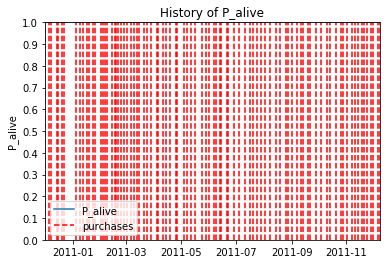

In [26]:
# Customer 14606
# frequent customer, alive throughout the year.
id = 14606
days_since_birth = 365
sp_trans = dfnew.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

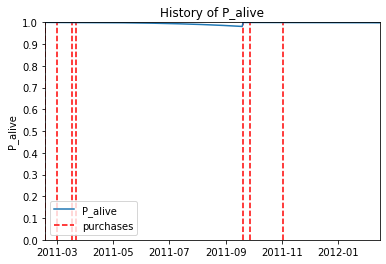

In [18]:
# Customer 12352    
# 6 repeated orders
id = 12352
days_since_birth = 365
sp_trans = dfnew.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

### 1.4 Gamma-Gamma model
Predict average monetary value per transaction. If we know the price and historical transactions of a specific customer, then we can apply Gamma-Gamma model to predict most likely monetary value **per transaction** in the future.    
#### Focus on customers with repurchase behavior
Focus on estimating the customers who had at least one repeat purchase. Because customer with only one purchase is very less likely to make additional purchase. It’s difficult to save/wake up these silent customers.

In [27]:
returning_customers_summary = modeldata[modeldata['frequency']>0]

In [29]:
# 64% customer left
len(returning_customers_summary)/len(modeldata)

0.6430053007605439

In [30]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])

print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


In [31]:
ggf.conditional_expected_average_profit(modeldata['frequency'], \
    modeldata['monetary_value']).head(10)

CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
12352.0    376.166864
12353.0    416.917667
12354.0    416.917667
12355.0    416.917667
12356.0    324.008941
dtype: float64

## 2. Machine Learning: Xgboost and Lightgbm Algorithm
Features:    
- customerID
- latetime: days between last transaction to now
- earlytime: days between first transaction to now
- freq: transaction frequency (whole history)
- freq_3m: transaction frequency (recent 3 months history)
    
Target: number of transactions in test set

In [63]:
dfnew.InvoiceDate

0         2010-12-01
1         2010-12-01
2         2010-12-01
3         2010-12-01
4         2010-12-01
             ...    
541904    2011-12-09
541905    2011-12-09
541906    2011-12-09
541907    2011-12-09
541908    2011-12-09
Name: InvoiceDate, Length: 397924, dtype: object

In [64]:
import datetime

dfnew_train = dfnew[dfnew.InvoiceDate <= datetime.date(2011, 8, 31)]
dfnew_test = dfnew[dfnew.InvoiceDate > datetime.date(2011, 8, 31)]

maxdate = dfnew_train.InvoiceDate.max()
mindate = dfnew_train.InvoiceDate.min()

dfnew_train['duration'] =  (maxdate - dfnew_train.InvoiceDate)/np.timedelta64(1, 'D')
# get time duration between the last transaction to now
dfsum1 = dfnew_train.groupby(['CustomerID'])['duration'].min().reset_index()
dfsum1.rename(columns = {'duration':'latetime'}, inplace = True)

# get time duration between the first transaction to now
dfsum2 = dfnew_train.groupby(['CustomerID'])['duration'].max().reset_index()
dfsum2.rename(columns = {'duration':'earlytime'}, inplace = True)

# get transaction frequency (whole history)
dfsum3 = dfnew_train.groupby(['CustomerID'])['InvoiceDate'].nunique().reset_index()
dfsum3.rename(columns={'InvoiceDate': 'freq'}, inplace=True)
# get transaction frequency (recent 3 months history)
dfsum4 = dfnew_train[dfnew_train.duration<91].groupby(['CustomerID'])['InvoiceDate'].nunique().reset_index()
dfsum4.rename(columns={'InvoiceDate': 'freq_3m'}, inplace=True)

dfsum = pd.merge(dfsum1, dfsum2, on=['CustomerID'], how='outer')
dfsum = pd.merge(dfsum, dfsum3, on=['CustomerID'], how='outer')
dfsum = pd.merge(dfsum, dfsum4, on=['CustomerID'], how='outer')

# get target: number of transactions in test set
dfsum_target = dfnew_test.groupby(['CustomerID'])['InvoiceDate'].nunique().reset_index()
dfsum_target.rename(columns={'InvoiceDate': 'target'}, inplace=True)
dfsum = pd.merge(dfsum, dfsum_target, on=['CustomerID'], how='left')
dfsum  = dfsum.fillna(0).sort_values(['target'], ascending = False)

In [77]:
dfsum['target'].describe()

count    3317.000000
mean        1.449201
std         2.460220
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        52.000000
Name: target, dtype: float64

In [78]:
dfsum.head(10)

,CustomerID,latetime,earlytime,freq,freq_3m,target
1463,14911.0,5.0,273.0,80,33.0,52.0
249,12748.0,1.0,273.0,70,29.0,44.0
3065,17841.0,3.0,273.0,73,29.0,39.0
1694,15311.0,12.0,273.0,62,20.0,28.0
1292,14606.0,3.0,273.0,65,19.0,24.0
366,12971.0,7.0,272.0,50,17.0,21.0
434,13089.0,0.0,269.0,47,13.0,19.0
134,12569.0,7.0,152.0,10,6.0,16.0
1315,14646.0,5.0,254.0,29,9.0,16.0
1248,14527.0,7.0,269.0,38,13.0,16.0


### xgb model

In [79]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

xgb_model = xgb.XGBRegressor(n_estimators=2200, objective='reg:linear', max_depth = 3)
 
predictors = ['latetime','earlytime', 'freq','freq_3m']
X = dfsum[predictors]
y = dfsum.target

x_trains, x_valids, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12)

xgb_model.fit(x_trains, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

In [80]:
y_pred = xgb_model.predict(x_valids)
rmse = mean_squared_error(y_valid, y_pred)**(1/2)
print('RMSE on test set: ', rmse)


RMSE on test set:  1.789839681695472


In [87]:
xgb_model2 = xgb.XGBRegressor(n_estimators=2200, objective='reg:linear', max_depth = 3)
xgb_model2.fit(X, y)
y_pred2 = xgb_model2.predict(X)
print('RMSE: ', mean_squared_error(y, y_pred2)**(1/2))
print('SMAPE', smape(y, y_pred2))
print('R2: ', r2_score(y, y_pred2))

RMSE:  0.9432251152502583
SMAPE 1.0779295245501
R2:  0.8529673202695269


#### Feature importance
importance_type:
- ‘weight’ - the number of times a feature is used to split the data across all trees.
- ‘gain’ - the average gain across all splits the feature is used in. most popular way.
- ‘cover’ - the average coverage across all splits the feature is used in. (yes/no proportion)
- ‘total_gain’ - the total gain across all splits the feature is used in.
- ‘total_cover’ - the total coverage across all splits the feature is used in.

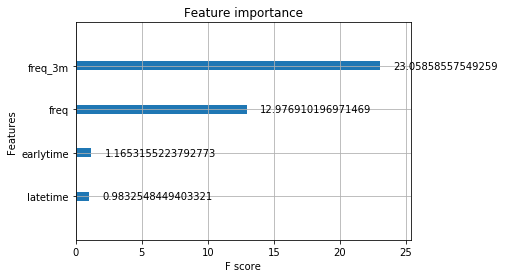

In [81]:
xgb.plot_importance(xgb_model, importance_type='gain')

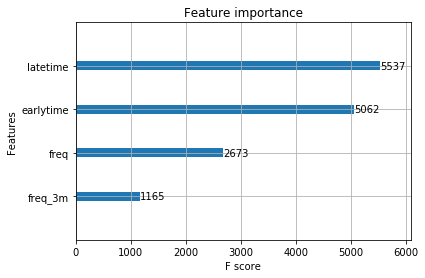

In [82]:
xgb.plot_importance(xgb_model, importance_type='weight')

### lgb model

In [83]:
import lightgbm as lgb

lgbparams = {
    'n_estimators': 2200, 
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',    
    'max_depth': 3, 
    'learning_rate': 0.02
}

lgb_model = lgb.LGBMRegressor(**lgbparams)
 
predictors = ['latetime','earlytime', 'freq','freq_3m']
X = dfsum[predictors]
y = dfsum.target

x_trains, x_valids, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12)

lgb_model.fit(x_trains, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.02, max_depth=3,
              metric='mse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=2200, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [84]:
y_pred = lgb_model.predict(x_valids)
rmse = mean_squared_error(y_valid, y_pred)**(1/2)
print('RMSE on test set: ', rmse)

RMSE on test set:  1.557216855982251


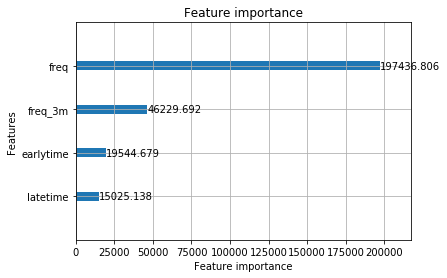

In [85]:
lgb.plot_importance(lgb_model, importance_type='gain')

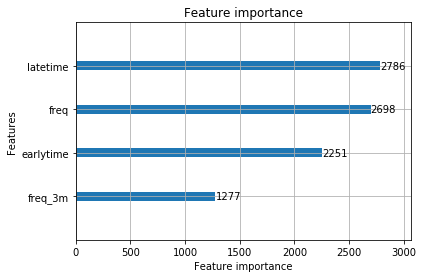

In [86]:
lgb.plot_importance(lgb_model) # defualt: weight

In [88]:
lgb_model2 = lgb.LGBMRegressor(**lgbparams)
lgb_model2.fit(X, y)
y_pred3 = lgb_model2.predict(X)
print('RMSE: ', mean_squared_error(y, y_pred3)**(1/2))
print('SMAPE', smape(y, y_pred3))
print('R2: ', r2_score(y, y_pred3))

RMSE:  1.373259592334425
SMAPE 1.1109920509253797
R2:  0.6883347065146813


## Probabilistic Modeling vs Machine Learning
**BG/NBD Model**
- RMSE:  1.6298
- R2:  0.5610
    
**Xgboost**
- RMSE:  0.9432
- R2:  0.8530

### Disadvantages of Probabilistic Model
- Only use transaction features. No capability to add other important features like age, gender, education, price, trading behaviors.
- Not accurate. The model is built on strong assumptions, which might not be accurate in practical application. True data often doesn’t follow the distribution. 

## 3. Recommendations
- **Champions**: recent, frequent, heavy spenders.     
    Reward these customers. They can become early adopters for new products and will help promote your brand.
- **Potential Loyalists**: recent, average frequency and spent a good amount.     
    Offer membership or loyalty programs or recommend related products to upsell them and help them become your Loyalists or Champions.
- **Can’t Lose Them**: used to be frequent, heavy spenders, but haven’t been visiting recently.     
    Bring them back with relevant promotions. Run surveys to find out what went wrong and avoid losing them to a competitor.
- **New Customers**: recent, spent a good amount, but not frequent shoppers.     
    Start building relationships with these customers by providing special offers to increase their visits.

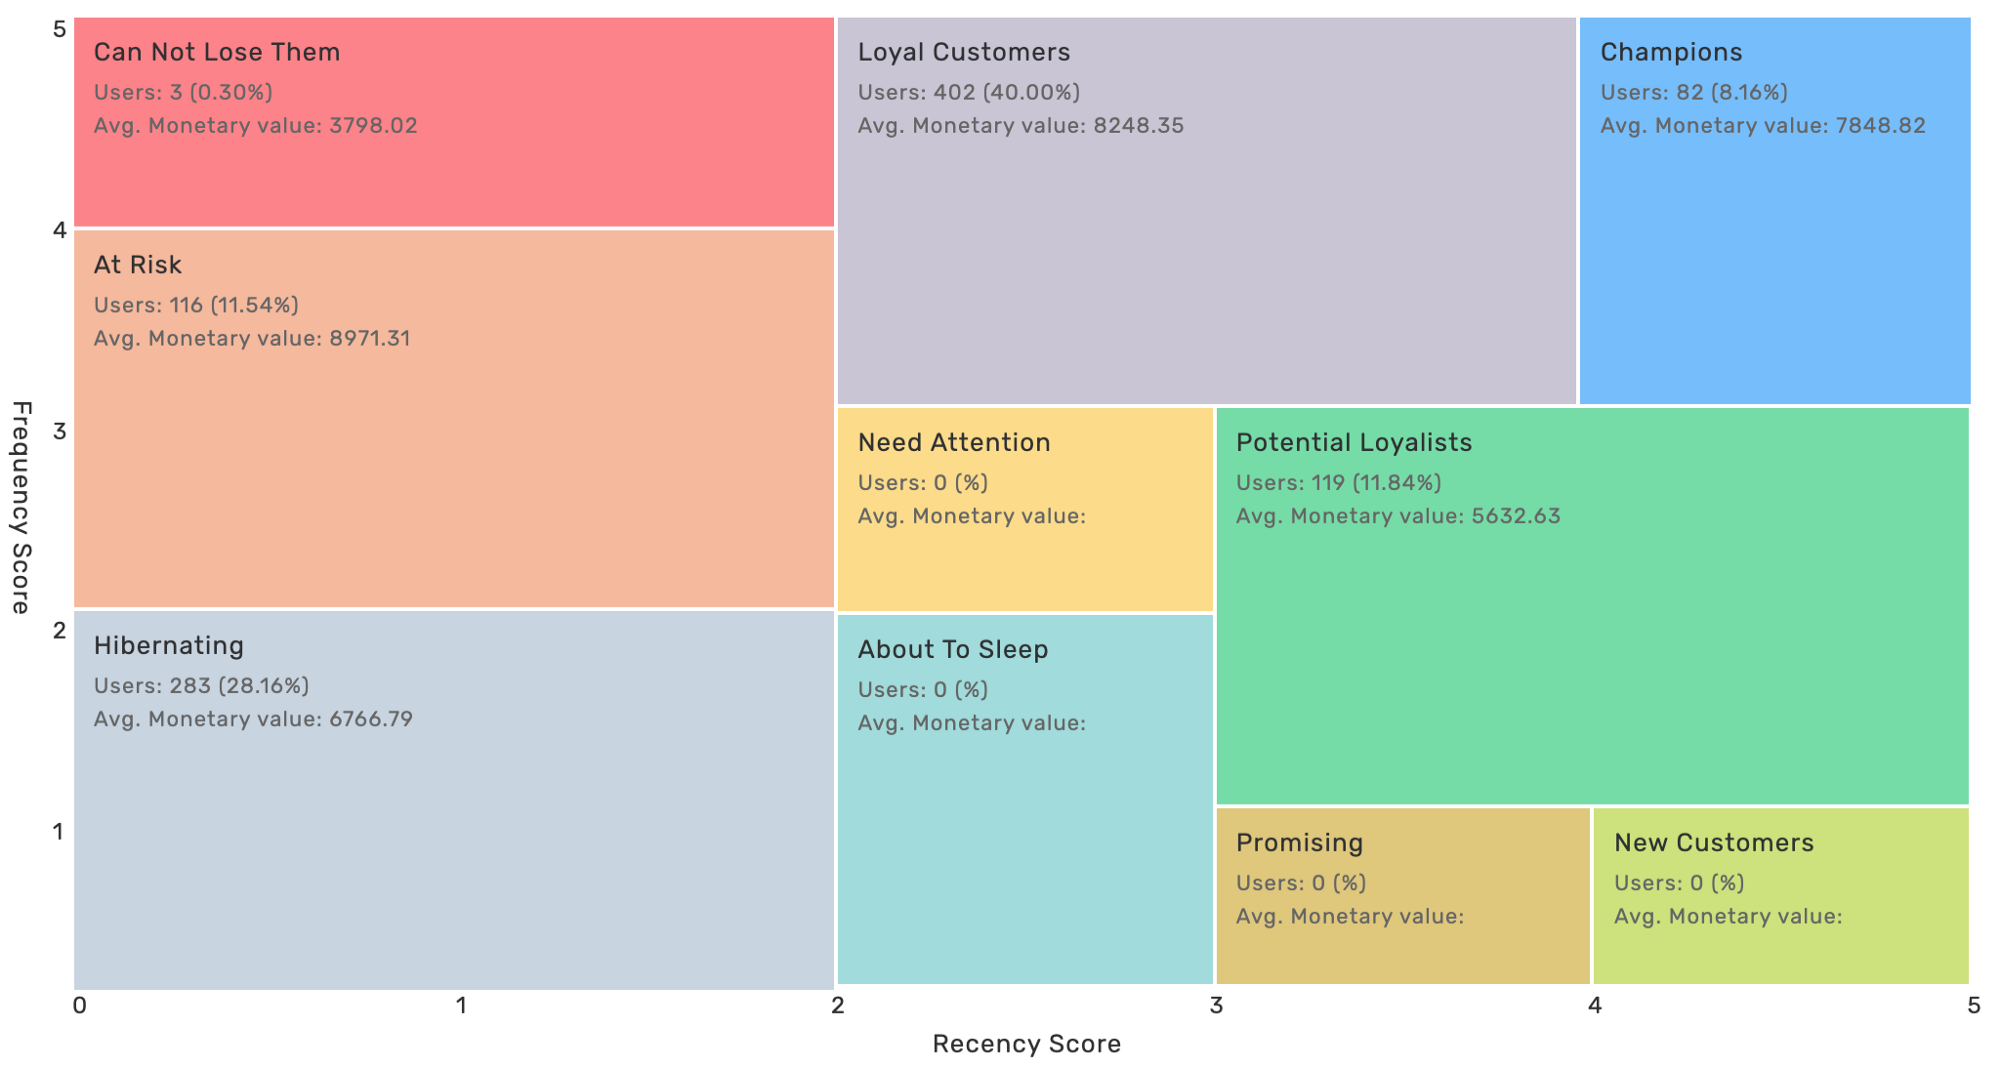
https://clevertap.com/blog/rfm-analysis/

## References
[1] BG/NBD Model    
https://medium.com/bolt-labs/understanding-the-customer-lifetime-value-with-data-science-c14dcafa0364    
[2] RFM Analysis    
https://www.putler.com/rfm-analysis/    
https://clevertap.com/blog/rfm-analysis/